In [1]:
import cv2
import numpy as np
from os.path import join
from PIL import Image
import matplotlib.pyplot as plt
from projeto_helper import BeerClassification

PATH = 'C:\\Users\\marco\\Google Drive\\ComputerScience\\Visão Computacional\\images\\Skol'

def getHomography(query_kpts, train_kpts, matches, threshold=3.0):
    """Returns a homography matrix to transform the train image to match
    the query. 

    Adapted from: https://colab.research.google.com/drive/11Md7HWh2ZV6_g3iCYSUw76VNr4HzxcX5

    Parameters
    ----------
    query_kpts : ndarray of cv2.Keypoint
        Query image keypoints.

    train_kpts : ndarray of cv2.Keypoint
        Train image keypoints.

    matches : cv2.matches
        Matched descriptors of both images, use BeerClassification.matcher.

    Returns
    -------
    H : ndarray
        Homography matrix
    """
    # convert the keypoints to numpy arrays
    train_kpts = np.float32([kp.pt for kp in train_kpts])
    query_kpts = np.float32([kp.pt for kp in query_kpts])

    if len(matches) > 4:
        # construct the two sets of points
        train_pts = np.float32([train_kpts[m.queryIdx] for m in matches])
        query_pts = np.float32([query_kpts[m.trainIdx] for m in matches])

        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(train_pts, query_pts, cv2.RANSAC, ransacReprojThreshold=threshold)
        return H
    else:
        return None

def trim(img):
    m = 680
    n = 2711
    i = 872
    j = 2095
    img_crop = img[m : n + 1, i : j + 1, :]
    return img_crop

def SIFT(
    query_img,
    train_img,
    nfeatures=0, # best = 4000, 68500
    nOctaveLayers=3, # best = 6, 69002
    contrastThreshold=0.04, 
    edgeThreshold=10, # best = 4, 70734
    sigma=1.6,
    ransacThreshold=3.0): # best = 5, 70877

    s = cv2.SIFT_create(nfeatures, nOctaveLayers, contrastThreshold, edgeThreshold, sigma)
    query_kpts, query_desc = s.detectAndCompute(query_img, None)
    train_kpts, train_desc = s.detectAndCompute(train_img, None)

    bf = cv2.BFMatcher(cv2.cv2.NORM_L2, crossCheck=True)
    matches = bf.match(train_desc, query_desc)
    matches = sorted(matches, key=lambda x:x.distance)

    H = getHomography(query_kpts, train_kpts, matches, ransacThreshold)
    width = query_img.shape[1]
    height = query_img.shape[0]
    train_img_t = cv2.warpPerspective(train_img, H, (width, height))

    query_img_s = cv2.GaussianBlur(query_img, (5, 5), cv2.BORDER_DEFAULT)
    train_img_s = cv2.GaussianBlur(train_img_t, (5, 5), cv2.BORDER_DEFAULT)
    img_diff = cv2.subtract(query_img_s, train_img_s)

    img_diff_trim = trim(img_diff)
    img_diff_gray = cv2.cvtColor(img_diff_trim, cv2.COLOR_RGB2GRAY)
    _, img_t = cv2.threshold(img_diff_gray, 50, 1, cv2.THRESH_BINARY)
    t = np.sum(img_t)

    fig, axs = plt.subplots(1, 2, figsize=(30, 10))
    img_match = cv2.drawMatches(train_img, train_kpts, query_img, query_kpts,
                                matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    axs[0].imshow(img_match)
    axs[0].set_title(f'kpts: {len(query_kpts)}')
    axs[1].imshow(img_t, 'gray')
    axs[1].set_title(f'pixels: {t}')
    plt.show()

    return t

In [2]:
bc = BeerClassification(PATH, ['0', '1'])
query_img = bc.getImage(bc.imgs[0])
train_img = bc.getImage(bc.imgs[75])
mask = plt.imread(join(PATH, 'mask0.jpg'))
query_img_m = cv2.bitwise_and(query_img, mask)

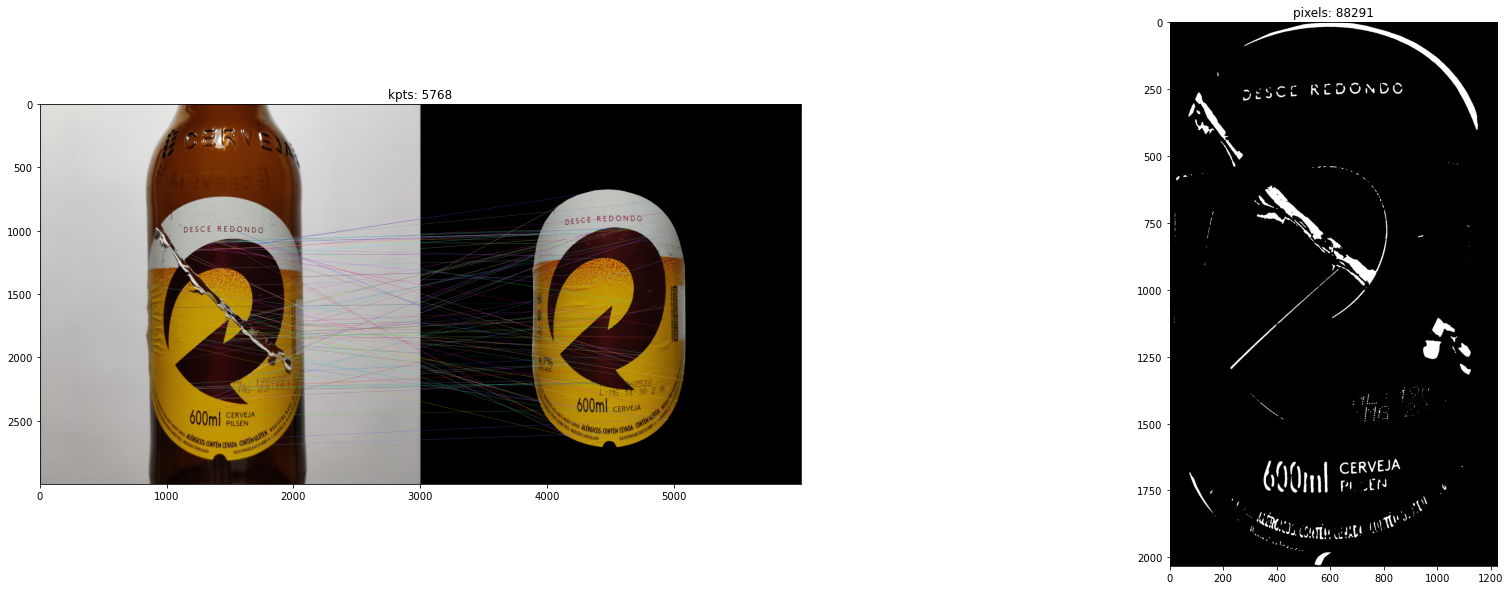

88291

In [3]:
SIFT(query_img_m, train_img)

1


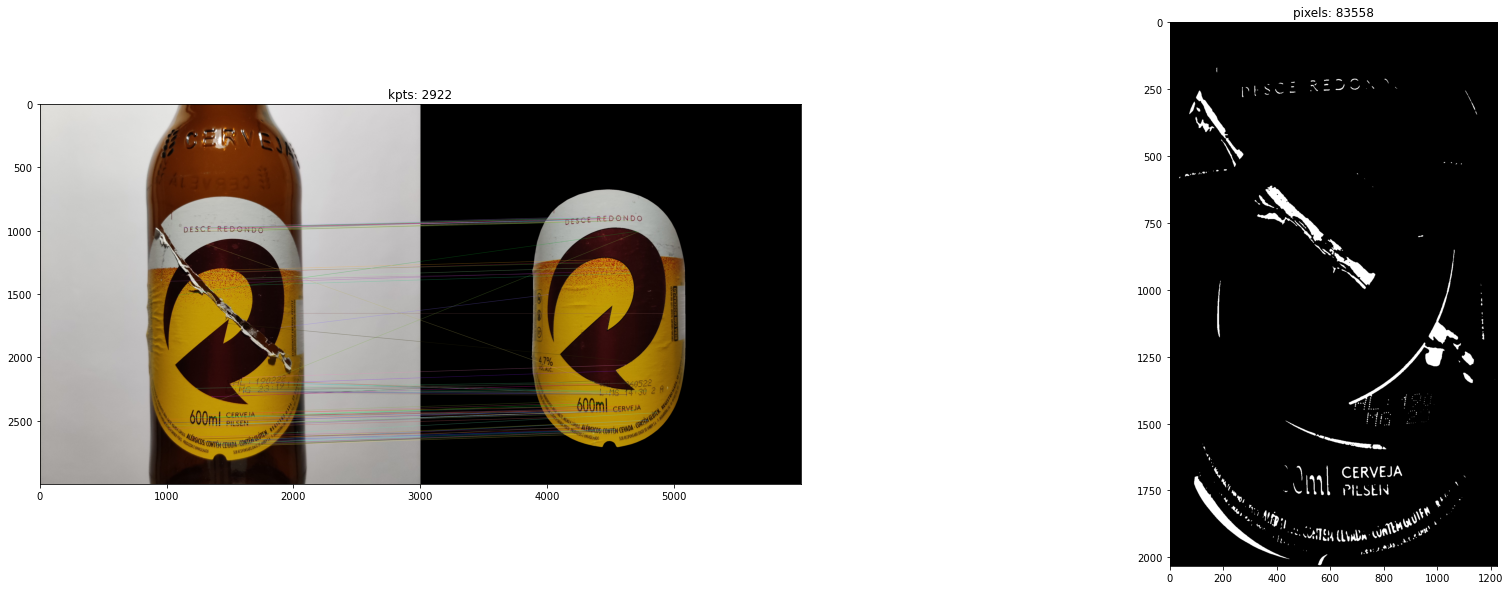

2


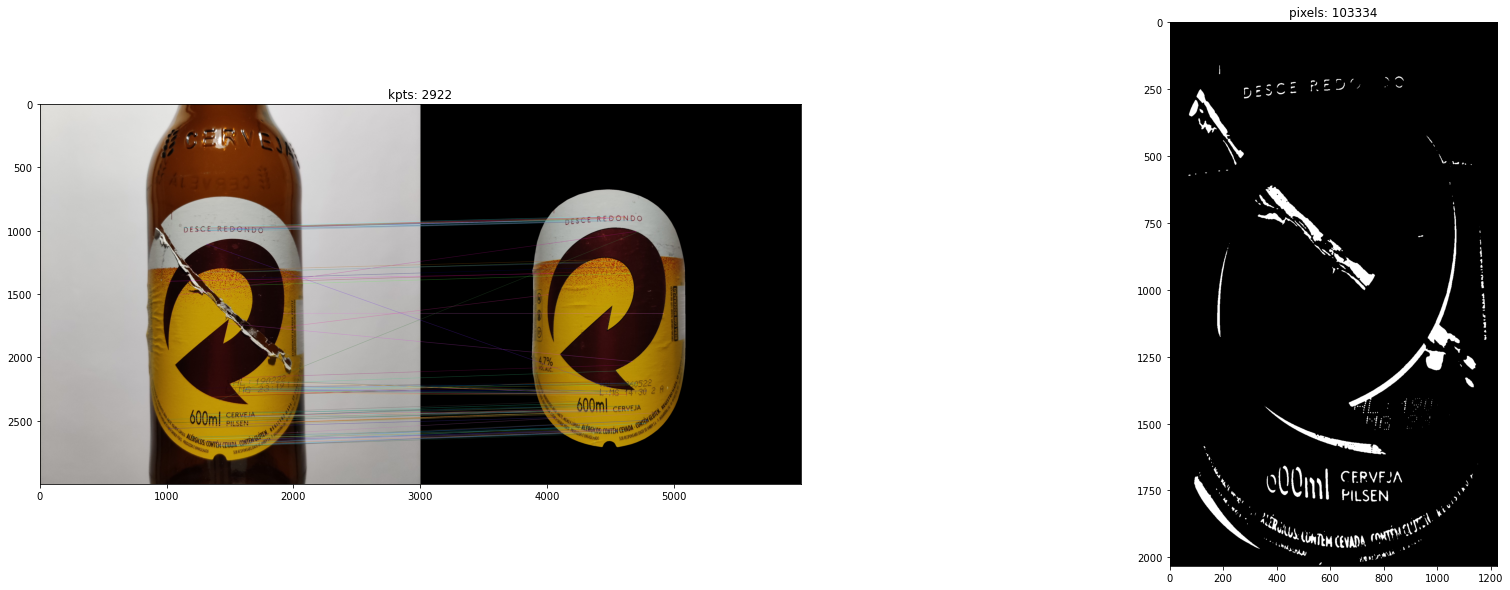

3


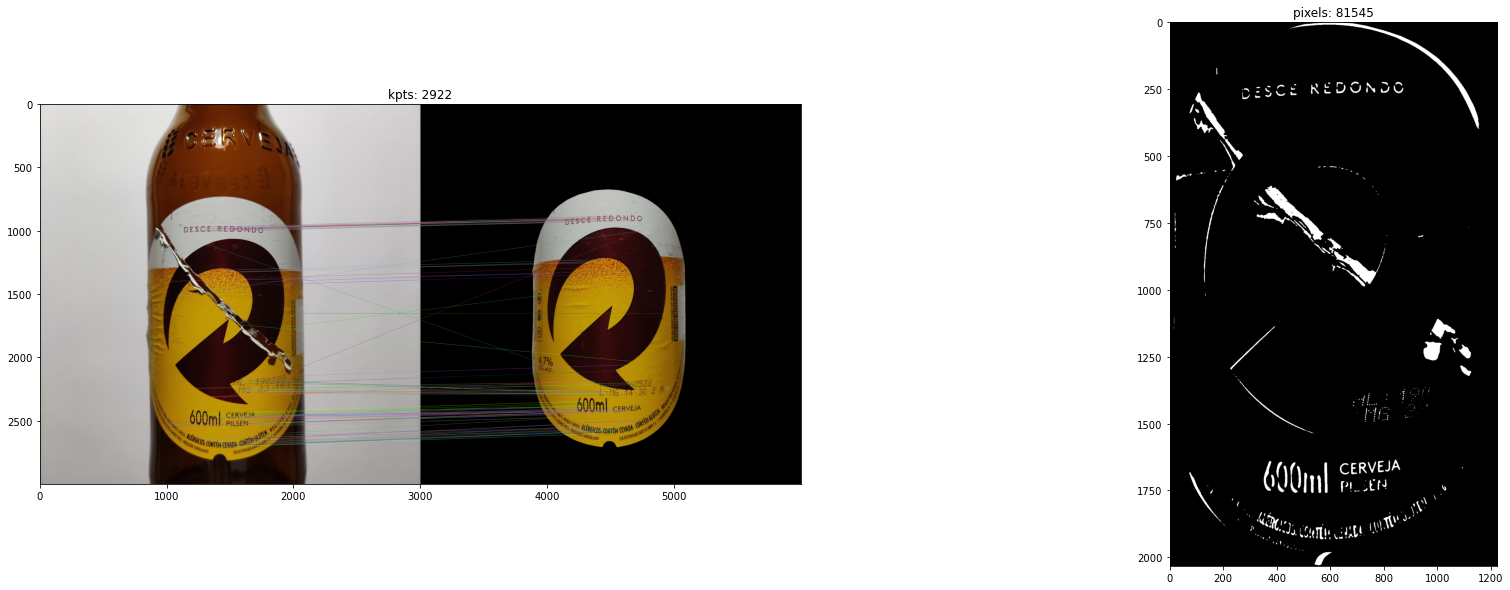

4


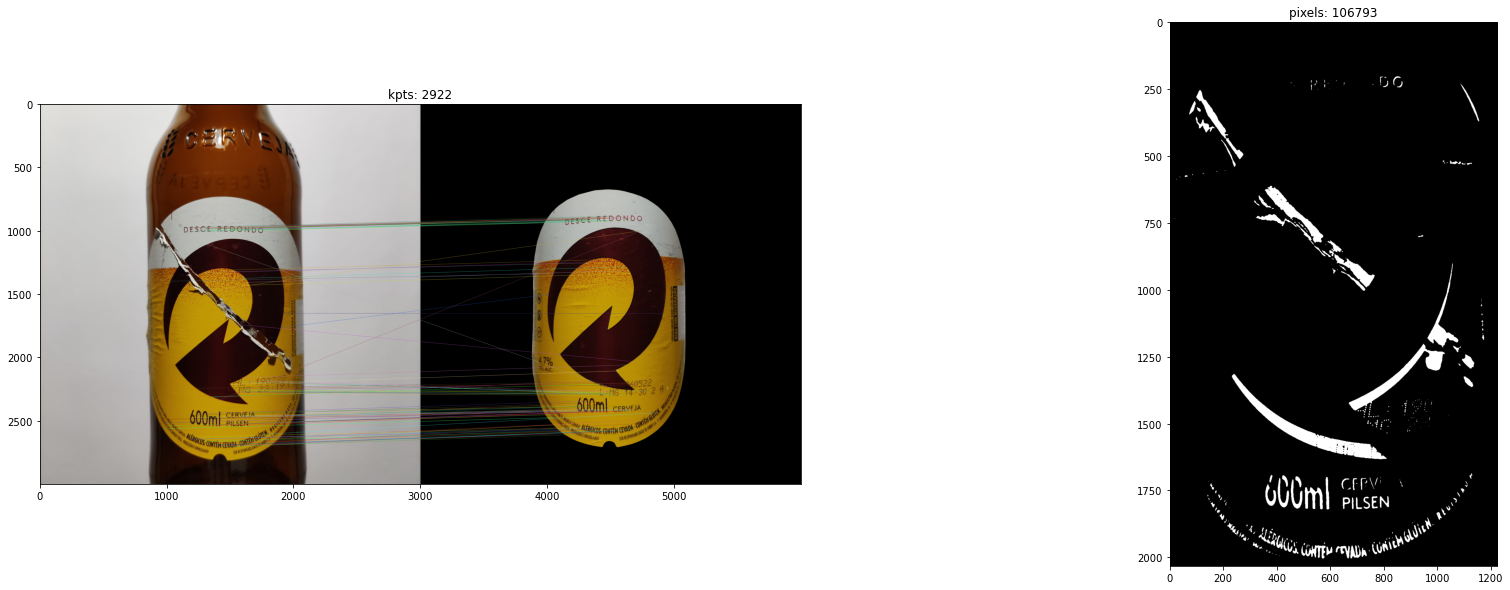

5


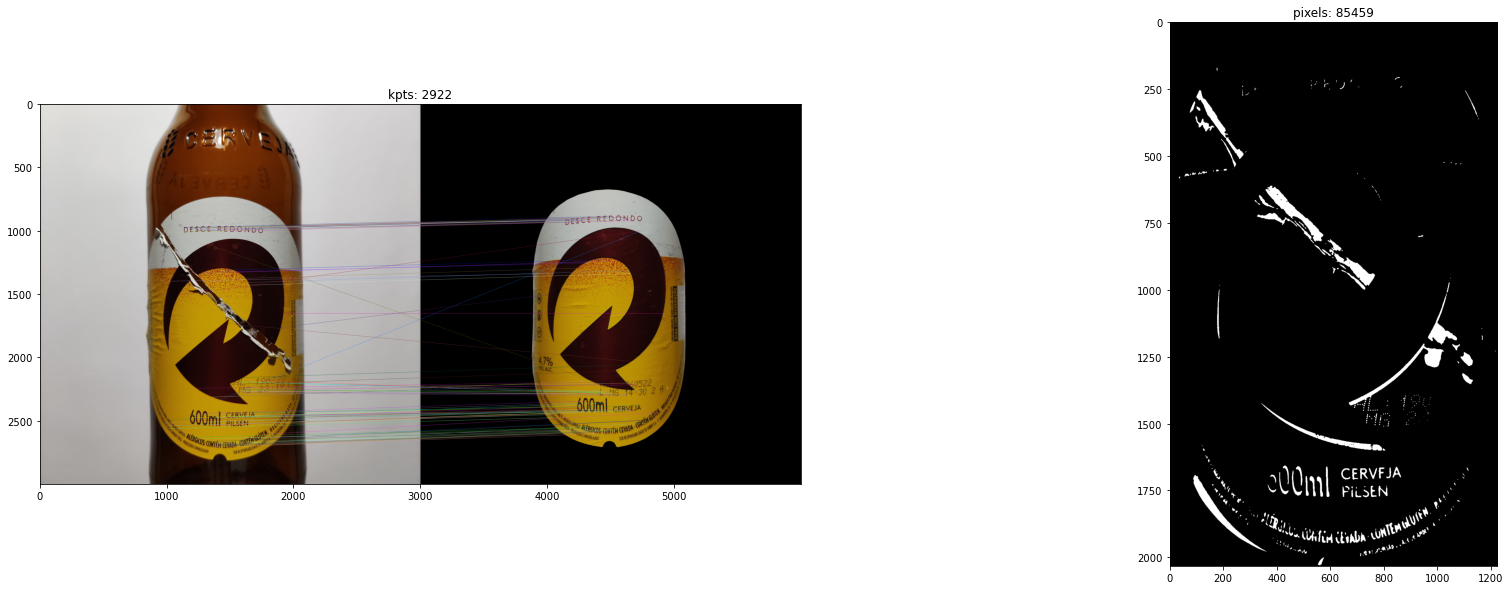

6


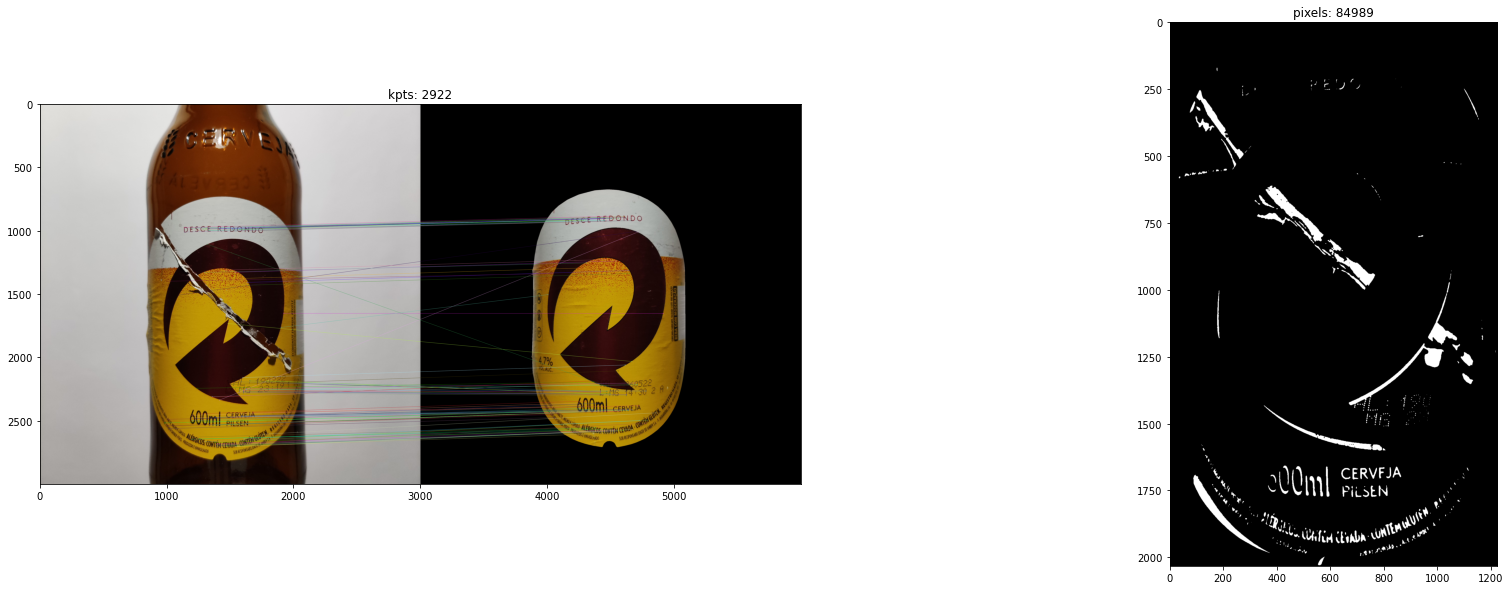

7


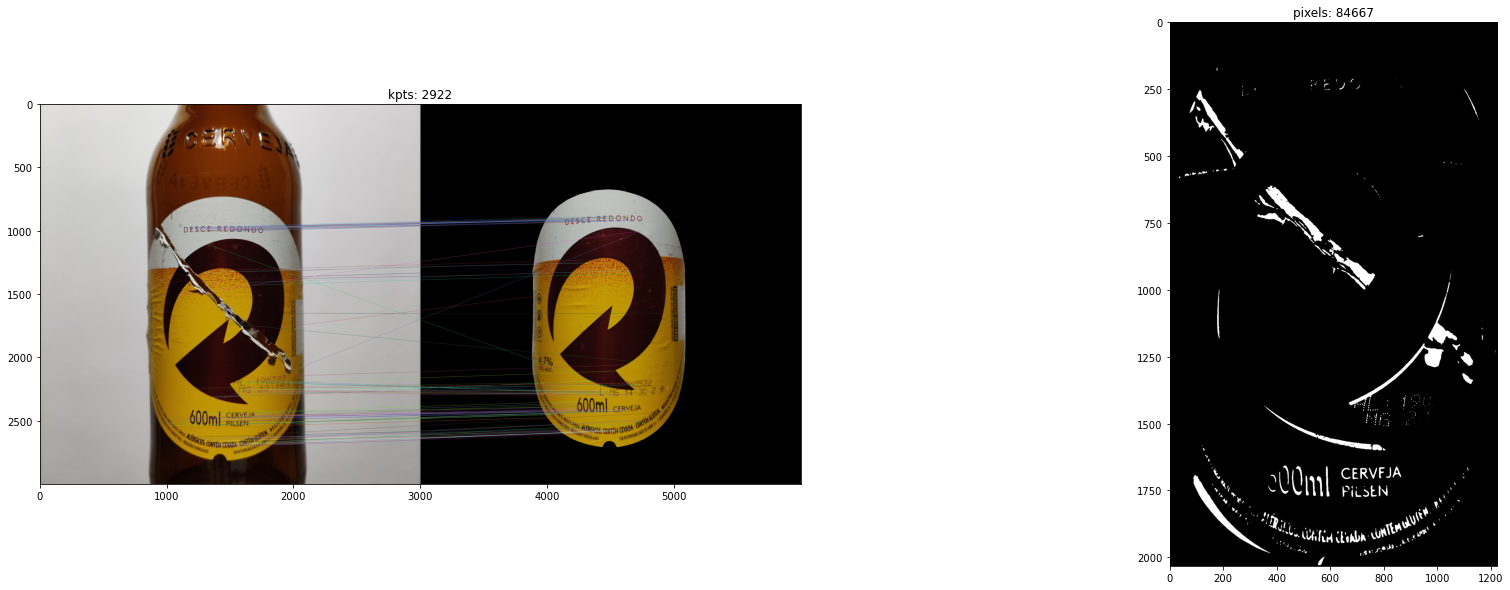

8


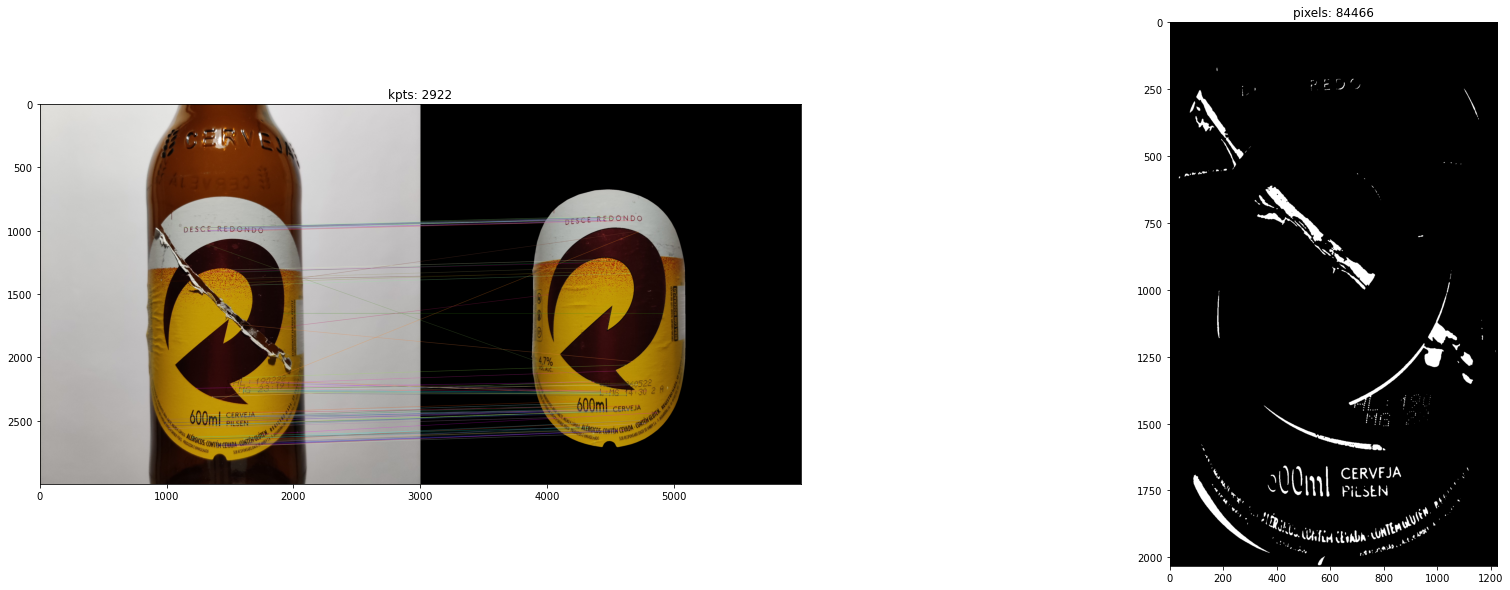

9


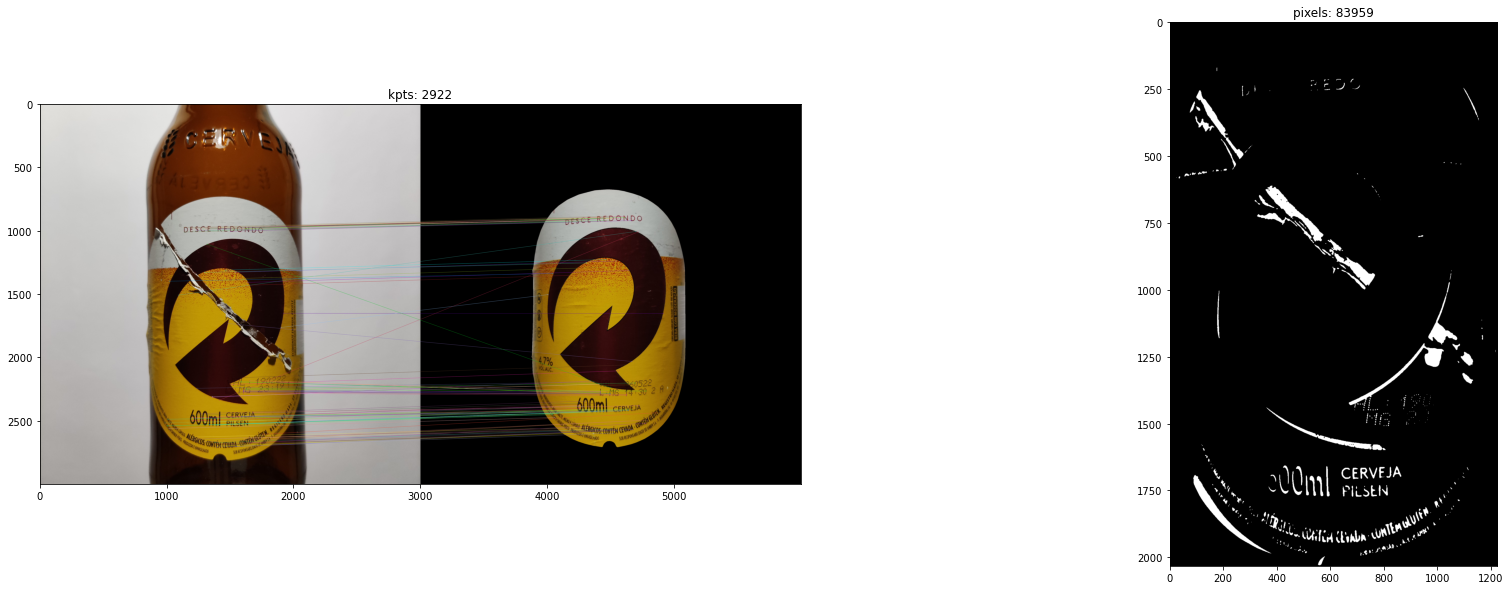

10


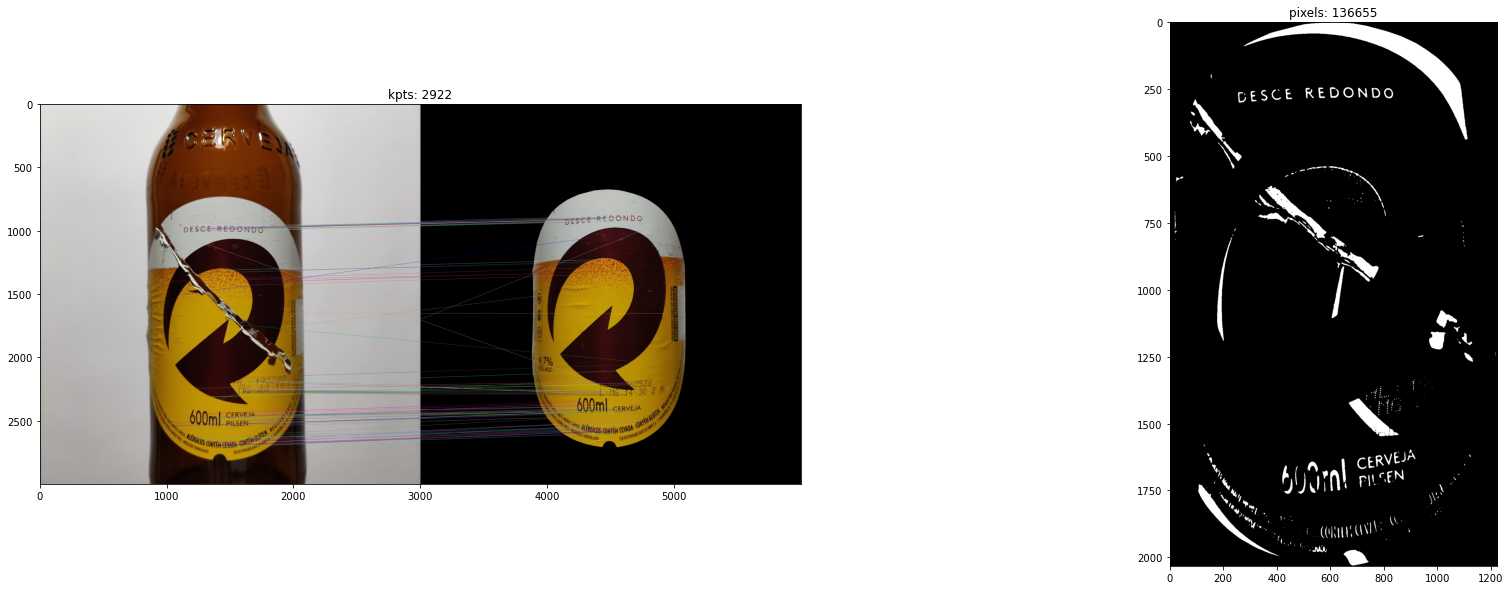

[83558, 103334, 81545, 106793, 85459, 84989, 84667, 84466, 83959, 136655]


In [4]:
results = []
for x in np.arange(1, 11, 1):
    print(x)
    r = SIFT(query_img_m, train_img, nfeatures=4000, nOctaveLayers=6, edgeThreshold=4, sigma=2.5, ransacThreshold=x)
    results.append(r)
print(results)

In [5]:
np.min(results)

81545